In [43]:
# Importing required libraries
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("Libraries imported successfully")


Libraries imported successfully


In [2]:
# Loading the smartphone dataset gathered from kaggle
df = pd.read_csv(r"C:\Users\vhsse\Downloads\smartphone_dataset.csv")
print("Dataset loaded successfully")
df.head()

Dataset loaded successfully


,Unnamed: 0,mobile_name,release_date,price,avg_rating,total_ratings,cpu,rear_camera,front_camera,display,ram_and_storage,battery_and_charging_speed,operating_system,5G|NFC|Fingerprint,expert_view
0,0,Samsung Galaxy S25 Ultra,"Release: 22 Jan, 2025","₹129,999",NaN,NaN,Snapdragon 8 Elite Octa core,200+50+10+50 MP Rear Camera,12 MP Front Camera,6.9″ (17.53 cm) 120Hz Dynamic AMOLED 2x Display,12 GB RAM | 256 GB Storage,5000 mAh | 45W Fast Charging,Android v15 OS,5G | NFC | Fingerprint Sensor,NaN
1,1,OnePlus 13,"Release: 10 Jan, 2025","₹69,998",NaN,NaN,Snapdragon 8 Elite Octa core,50+50+50 MP Rear Camera,32 MP Front Camera,6.82″ (17.32 cm) 120Hz LTPO AMOLED Display,12 GB RAM | 256 GB Storage,6000 mAh | 100W Fast Charging,Android v15 OS,5G | NFC | Fingerprint Sensor,The OnePlus 13 aims to reclaim the brand's cro...
2,2,Samsung Galaxy S25,"Release: 22 Jan, 2025","₹80,999",NaN,NaN,Snapdragon 8 Elite Octa core,50+12+10 MP Rear Camera,12 MP Front Camera,6.2″ (15.75 cm) 120Hz Dynamic AMOLED 2x Display,12 GB RAM | 256 GB Storage,4000 mAh | 25W Fast Charging,Android v15 OS,5G | NFC | Fingerprint Sensor,NaN
3,3,Samsung Galaxy M35 5G,"Release: 20 Jul, 2024","₹16,999",4.4,"8,220 Ratings",Samsung Exynos 1380 Octa core,50+8+2 MP Rear Camera,13 MP Front Camera,6.6″ (16.76 cm) 120Hz Super AMOLED Display,6 GB RAM | 128 GB Storage,6000 mAh | 25W Fast Charging,Android v14 OS,5G | NFC | Fingerprint Sensor,The Samsung Galaxy M35 offers solid performanc...
4,4,Motorola Edge 50 Fusion,"Release: 22 May, 2024","₹21,197",4.5,16.9K Ratings,Snapdragon 7s Gen 2 Octa core,50+13 MP Rear Camera,32 MP Front Camera,6.67″ (16.94 cm) 144Hz P-OLED Display,8 GB RAM | 128 GB Storage,5000 mAh | 68W Fast Charging,Android v14 OS,5G | NFC | Fingerprint Sensor,Moto Edge 50 Fusion has a premium design and s...


In [10]:
#Listing all the columns
df.columns

Index(['Unnamed: 0', 'mobile_name', 'release_date', 'price', 'avg_rating',
       'total_ratings', 'cpu', 'rear_camera', 'front_camera', 'display',
       'ram_and_storage', 'battery_and_charging_speed', 'operating_system',
       '5G|NFC|Fingerprint', 'expert_view'],
      dtype='object')

In [7]:
# Removing ₹ symbol and commas from the price and converting them to float
df['price_cleaned'] = df['price'].str.replace(r'[₹,]','',regex=True).astype(float)
df = df.dropna(subset=['price_cleaned'])
df[['mobile_name', 'price','price_cleaned']].head()


,mobile_name,price,price_cleaned
0,Samsung Galaxy S25 Ultra,"₹129,999",129999.0
1,OnePlus 13,"₹69,998",69998.0
2,Samsung Galaxy S25,"₹80,999",80999.0
3,Samsung Galaxy M35 5G,"₹16,999",16999.0
4,Motorola Edge 50 Fusion,"₹21,197",21197.0


In [3]:
#dimensions of the dataset
df.shape

(5263, 15)

In [27]:
# Dropping rows having missing values in important spec fields
df = df.dropna(subset=['ram_and_storage', 'rear_camera', 'battery_and_charging_speed'])
print("Remaining entries:", len(df))


Remaining entries: 3425


In [5]:
# Extracting numeric values using regex
def extract_ram(text):
    match = re.search(r'(\d+)\s*GB', str(text))
    return int(match.group(1)) if match else np.nan

def extract_camera(text):
    match = re.search(r'(\d+)\s*MP', str(text ))
    return int(match.group(1)) if match else np.nan

def extract_battery(text):
    match = re.search(r'(\d{4,5})', str( text))
    return int(match.group(1)) if match else np.nan

df['ram_gb'] = df['ram_and_storage'].apply(extract_ram)
df['camera_mp'] = df['rear_camera'].apply( extract_camera)
df['battery_mah'] = df['battery_and_charging_speed'].apply(extract_battery)

df = df.dropna(subset=['ram_gb','camera_mp','battery_mah'])
df[['ram_gb','camera_mp','battery_mah']].describe()


,ram_gb,camera_mp,battery_mah
count,3435.000000,3435.000000,3435.000000
mean,5.053857,8.919942,4066.868413
std,3.260530,12.269577,1346.128433
min,1.000000,1.000000,1000.000000
25%,3.000000,2.000000,3000.000000
50%,4.000000,5.000000,4300.000000
75%,8.000000,12.000000,5000.000000
max,32.000000,200.000000,22000.000000


In [9]:
# Select and scale relevant features
features = df[['price_cleaned','ram_gb', 'camera_mp','battery_mah']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("Features are scaled and ready for  clustering")


Features are scaled and ready for clustering


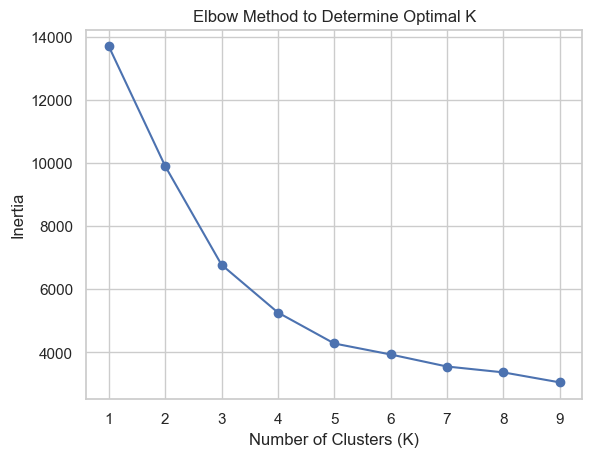

In [10]:
#finding the best K using elbow method
inertia = []
for k in range(1, 10):
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(features_scaled )
    inertia.append(model.inertia_)

plt.plot(range(1, 10),inertia,  marker='o')
plt.title("Elbow Method for Optimal K value determination")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [13]:
# Apply KMeans with k=6 to match the 6 label categories
k = 6  
kmeans = KMeans(n_clusters= k,random_state=42)
df = df.copy()
df.loc[:, 'cluster']= kmeans.fit_predict( features_scaled)
df[['mobile_name','cluster']].head()


,mobile_name,cluster
0,Samsung Galaxy S25 Ultra,3
1,OnePlus 13,5
2,Samsung Galaxy S25,2
3,Samsung Galaxy M35 5G,0
4,Motorola Edge 50 Fusion,0


In [14]:
# Reducing to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform( features_scaled)
df['pca1']= pca_result[:, 0]
df['pca2']= pca_result[:, 1]


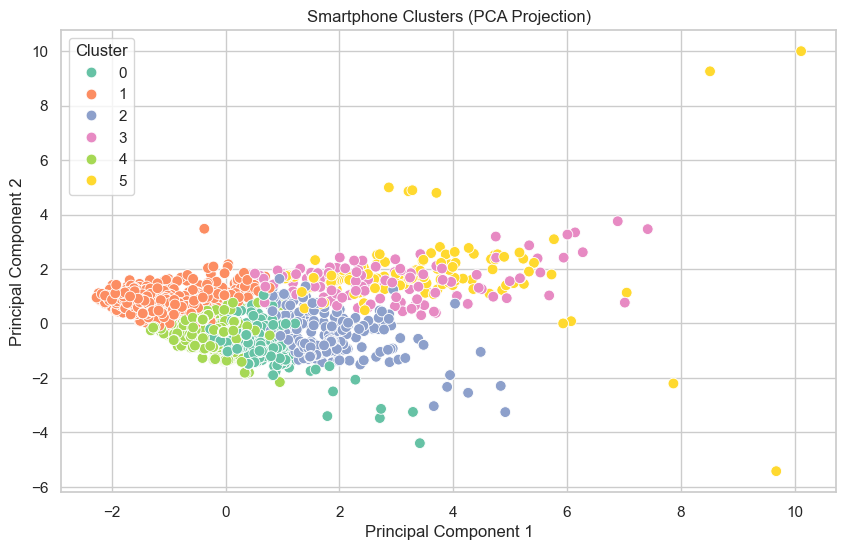

In [15]:
# Plotting the clusters using seaborn 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df,x='pca1', y='pca2',hue='cluster',palette='Set2', s=60)
plt.title("Smartphone Clusters (PCA Projection)")
plt.xlabel("Principal Component 1 ")
plt.ylabel(" Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [16]:
# Getting average specs per cluster
summary = df.groupby('cluster')[['price_cleaned','ram_gb', 'camera_mp','battery_mah']].mean().round(2)
summary.rename(columns={
    'price_cleaned': 'Avg Price (₹)',
    'ram_gb':'Avg RAM (GB)',
    'camera_mp': 'Avg Camera (MP)',
    'battery_mah':'Avg Battery (mAh)'
},inplace=True)

summary


,Avg Price (₹),Avg RAM (GB),Avg Camera (MP),Avg Battery (mAh)
cluster,,,,
0,18800.42,7.11,3.58,4910.31
1,10583.43,2.50,8.22,2548.61
2,41562.44,10.92,7.60,4721.12
3,115029.03,8.15,15.87,3918.05
4,9383.21,3.44,6.07,4772.56
5,36134.98,9.46,53.70,5413.24


In [34]:
# Manually mapping cluster numbers to meaningful labels based on analysis of cluster_summary
# Viewing cluster_summary output first before adjusting the mapping below
cluster_labels = {
    0: "budget bangers",
    1:  "all rounders",
    2: "battery kings",
    3:  "camera monsters",
    4: "gaming gorillas",
    5: "flagship chads"
}

# Applying mapping to the dataframe
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Viewing a few labeled entries
df[['mobile_name','price_cleaned','ram_gb','camera_mp','battery_mah','cluster_label']].head(10)


,mobile_name,price_cleaned,ram_gb,camera_mp,battery_mah,cluster_label
0,Samsung Galaxy S25 Ultra,129999.0,12.0,50,5000.0,camera monsters
1,OnePlus 13,69998.0,12.0,50,6000.0,flagship chads
2,Samsung Galaxy S25,80999.0,12.0,10,4000.0,battery kings
3,Samsung Galaxy M35 5G,16999.0,6.0,2,6000.0,budget bangers
4,Motorola Edge 50 Fusion,21197.0,8.0,13,5000.0,budget bangers
5,Moto G85,17990.0,8.0,8,5000.0,budget bangers
6,vivo V40,34999.0,8.0,50,5500.0,flagship chads
7,OnePlus 13R,42998.0,12.0,50,6000.0,flagship chads
8,vivo T3 Pro,22999.0,8.0,8,5500.0,budget bangers
9,Xiaomi Redmi Note 14 Pro+ 5G,30999.0,8.0,50,6200.0,flagship chads


Silhouette Score: 0.37687887392892355
Inertia: 3927.8175008374287


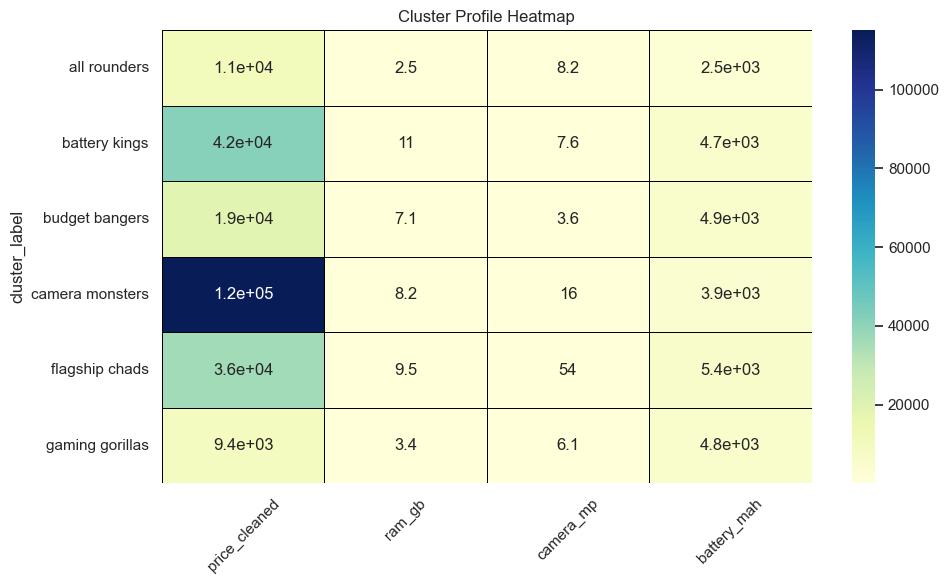

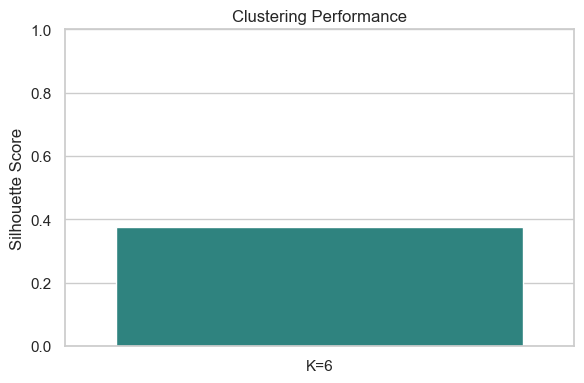

In [35]:
# Cluster Evaluation & Metrics Visualization

from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating Silhouette Score and Inertia
sil_score = silhouette_score(features_scaled, df['cluster'])
inertia = kmeans.inertia_
print("Silhouette Score:",sil_score)
print("Inertia:", inertia)
# Building cluster summary for heatmap visualization
metrics_df = df.groupby('cluster_label')[['price_cleaned', 'ram_gb', 'camera_mp', 'battery_mah']].mean().round(2)
metrics_df = metrics_df.sort_index()
# Heatmap for spec comparison across clusters
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', linewidths=0.5, linecolor='black')
plt.title("Cluster Profile Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Barplot drawn for Silhouette Score vs Model Label
plt.figure(figsize=(6, 4))
sns.barplot(x=["K=6"], y=[sil_score], hue=["KMeans (K=6)"], palette="viridis", legend=False)
plt.ylabel("Silhouette Score")
plt.title("Clustering Performance")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [42]:
#function for recommending Smartphones by Cluster Name

def get_phones_by_cluster(cluster_name, n=5):
    """
    this function returns the first n smartphones from the specified cluster label.
    
    Parameters taken by function:
        cluster_name (str): the cluster label (ex:Battery Kings)
        n (int): number of smartphones to return
    
    function returns the following:
        pandas dataFrame or string of Smartphones in the given cluster
    """
    # Checking if the cluster exists or not
    clusterName =cluster_name.lower()
    if clusterName not in df['cluster_label'].unique():
        return f" Cluster '{clusterName}' not found. Available clusters: {df['cluster_label'].unique().tolist()}"
    
    # Filtering smartphones from the specified cluster
    phones = df[df['cluster_label'] == cluster_name]
    
    # Sorting based on  RAM and battery 
    result = phones[['mobile_name', 'price_cleaned', 'ram_gb', 'camera_mp', 'battery_mah']].sort_values(
        by=['ram_gb', 'battery_mah'], ascending=[False, False]
    ).head(n)
    
    return result

#  Example usage:
print(get_phones_by_cluster("flagship chads", n=5))


           mobile_name  price_cleaned  ram_gb  camera_mp  battery_mah
205     OnePlus 13 1TB        89998.0    24.0         50       6000.0
17       vivo X200 Pro        94999.0    16.0        200       6000.0
139   iQOO 13 5G 512GB        59999.0    16.0         50       6000.0
310  OnePlus 13R 512GB        49998.0    16.0         50       6000.0
448   OnePlus 13 512GB        76998.0    16.0         50       6000.0
